# Bordas e Linhas

## Descrição

Este conjunto de problemas é o seu primeiro projeto de “visão” onde você calcula uma “resposta” - que é alguma descrição estrutural ou semântica do que está em uma imagem. Você encontrará bordas e objetos. Você aprenderá que alguns métodos funcionam bem para situações cuidadosamente controladas e quase não funcionam quando você relaxa essas restrições.

**REGRAS**: Você pode usar funções prontas de processamento de imagem para encontrar bordas, como Canny ou outros operadores. Não se esqueça de que eles têm uma variedade de parâmetros e você pode precisar experimentá-los. No entanto,  VOCÊ NÃO PODE USAR NENHUMA FERRAMENTA DE HOUGH. Por exemplo, você precisa escrever suas próprias estruturas de dados de matriz de acumulador e código para votação e localização de pico.

## Questões

### 1. Linhas em um Xadrez

Esta é uma imagem de teste para a qual a resposta deve ser clara, onde os limites do “objeto” são apenas linhas.

<img src="images/ps1-input0.png" width="250"/>


**A -** Carregue a imagem `images/ps1-input0.png` em escalas de cinza e gere uma imagem de borda - uma imagem binária com pixels brancos (1) nas bordas e pixels pretos (0) em outros lugares.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
img = cv2.imread("images/ps1-input0.png")
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

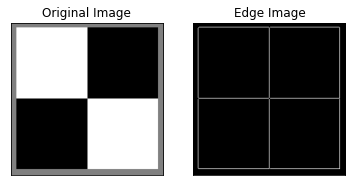

True

In [2]:
edges = cv2.Canny(img,100,200)
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

cv2.imwrite("canny.png", edges) 

### 2. Detecção de Linhas

Implemente um método de transformação de Hough para localizar linhas. Observe que o sistema de coordenadas usado tem sua origem no canto superior esquerdo da imagem e com o eixo $y$ apontando para baixo. Assim, o pixel correspondente às coordenadas $(x, y)$ deve votar em parâmetros de linha $(\rho, \theta)$ onde  $\rho = x \cos(\theta) + y \sin(\theta)$ e $\theta = \arctan{x/y}$.

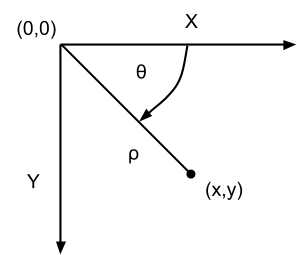

Isso tem o efeito de tornar a direção angular positiva no sentido horário em vez de no sentido anti-horário na convenção usual.

**A -** Escreva uma função `hough_lines_acc()` que calcula a transformação de Hough para linhas e produz um acumulador H, que representa o espaço paramétrico $(\rho, \theta)$ discretizado com a resolução radial e angular desejada.
 <img src="https://www.learnopencv.com/wp-content/uploads/2019/03/hough-transform-accumulator-1024x1024.png" width="300"/>

Qualquer compartimento (*bin*) nessa matriz 2D corresponde a uma linha e damos o nome acumulador porque usaremos os compartimentos desse array para coletar evidências sobre quais linhas existem na imagem. 

A função deve receber dois parâmetros além da imagem binária de bordas:
 1. `rho` - resolução radial $\rho$ do acumulador em pixels;
 2. `theta` - resolução angular $\theta$ do acumulador em radianos;

A função deve retornar três objetos:
 1. O *grid* acumulador de hough H em que cada posição representa o número de votos da linha com parâmetros $(\rho, \theta)$;
 2. Os vetor de valores $\theta$ que correspondem às colunas do *grid* H;
 3. Os vetor de valores $\rho$ que correspondem às linhas do *grid* H.

In [3]:
import math
import heapq

In [4]:
num_angle_buckets = 720
max_rho = 0
num_rho_buckets = 0

In [5]:
def init(img):
    global max_rho
    global num_rho_buckets
    (width, height, depth) = img.shape
    max_rho = math.ceil(max(width, height) * math.sqrt(2))
    num_rho_buckets = 2 * int(max_rho / 2)

# Use 0-pi radians.  Using 0-2pi just repeats the same lines in the opposite direction.
def bucket_to_radians(bucket):
    return math.pi * float(bucket) / float(num_angle_buckets)

def radians_to_bucket(angle):
    return int(float(num_angle_buckets) * float(angle) / math.pi)

def bucket_to_rho(bucket):
    return 2 * max_rho * ((bucket) / float(num_rho_buckets) - 0.5)

def rho_to_bucket(rho):
    return int(float(num_rho_buckets) * ((rho / (2 * max_rho)) + 0.5))

In [6]:
def hough_line_acc(hs, x, y):
    for bucket in range(num_angle_buckets):
        theta = bucket_to_radians(bucket)
        rho = x * math.cos(theta) + y * math.sin(theta)
        hs[rho_to_bucket(rho), bucket] += 1
def hough_lines_acc(edges):
    "Accumulates Hough lines"
    #edges = cv2.cvtColor(edges, cv2.COLOR_BGR2GRAY)
    (rows, cols) = edges.shape
    houghSpace = np.zeros((num_rho_buckets, num_angle_buckets), np.uint8)
    for x in range(cols):
        for y in range(rows):
            if edges[y, x] != 0:
                hough_line_acc(houghSpace, x, y)
    dst = np.zeros(shape=(5,2))
    cv2.normalize(houghSpace, dst,0,255,cv2.NORM_L1)
    return houghSpace

**B -** Aplique a função `hough_lines_acc()` na imagem da Parte I e exiba o acumulador de hough H.

In [7]:
img = cv2.imread("images/ps1-input0.png")
init(img)
grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
smooth = grey
houghSpace = hough_lines_acc(edges)

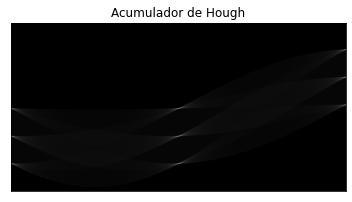

In [8]:
plt.title('Acumulador de Hough'), plt.xticks([]), plt.yticks([])
plt.imshow(houghSpace,cmap = 'gray')

**C -** Escreva uma função `hough_peaks()` que encontre os índices do *grid* acumulador (aqui, parâmetros de linha) que correspondem aos máximos locais e tenham um número mínimo de votos especificado. Observe que você precisa retornar uma matriz com formato `(número_de_linhas_encontradas, 2)` em que os $\rho$s estão na coluna 0 os $\theta$s na coluna 1. 

In [9]:
def hough_peaks(hs, n):
    "Find strongest lines in hough_space"
    heap = []
    for rho in range(num_rho_buckets):
        for angle in range(num_angle_buckets):
            heapq.heappush(heap, (hs[rho, angle], rho, angle))
    heapq.heapify(heap)
    result = []
    for (value, rho, angle) in heapq.nlargest(n, heap):
        result.append((rho, angle))
    return result

**D -** Escreva uma função `hough_lines_draw()` para desenhar linhas coloridas que correspondam aos picos encontrados na matriz do acumulador. Isso significa que você precisa pesquisar os valores $\rho$, $\theta$ usando os índices de pico e, em seguida, convertê-los (de volta) para parâmetros de linha em coordenadas cartesianas.

In [10]:
def hough_draw_peaks(hs, peaks):
    for (rho_bucket, angle_bucket) in peaks:
        cv2.circle(hs, (angle_bucket, rho_bucket), 4, 255)

def hough_draw_lines(img, lines):
    for (rho_bucket, angle_bucket) in peaks:
        # rho = x * cos(theta) + y * sin(theta)
        # y = 0 ==> x = rho / cos(theta)
        # x = 0 ==> y = rho / sin(theta)
        # We can draw the line between these points
        # Need to check for 0's
        green = (0, 255, 0)
        theta = bucket_to_radians(angle_bucket)
        rho = bucket_to_rho(rho_bucket)
        s = math.sin(theta)
        c = math.cos(theta)
        if (abs(c) < 0.001):
            y = int(rho / s)
            cv2.line(img, (1000, y), (0, y), green, 1)
        elif (abs(s) < 0.001):
            x = int(rho / c)
            cv2.line(img, (x, 0), (x, 1000), green, 1)
        else:
            x = int(rho / c)
            y = int(rho / s)
            cv2.line(img, (x, 0), (0, y), green, 1)

            # y = 1000 ==> x = (rho - 1000 * sin(theta)) / cos(theta)
            x2 = int((rho - 1000 * s) / c)
            cv2.line(img, (x, 0), (x2, 1000), green, 1)

            # XXX Need to take care of some other cases as well


In [11]:
img = cv2.imread("canny.png")
init(img)
grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
smooth = grey
houghSpace = hough_lines_acc(edges)
peaks = hough_peaks(houghSpace, 10)
hough_draw_peaks(houghSpace, peaks)
hough_draw_lines(img, peaks)

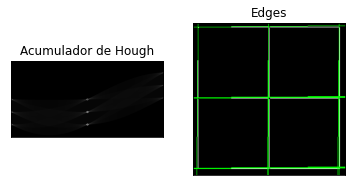

In [12]:
plt.subplot(121),plt.imshow(houghSpace,cmap = 'gray')
plt.title('Acumulador de Hough'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img,cmap = 'gray')
plt.title('Edges'), plt.xticks([]), plt.yticks([])
plt.show()

**E -** Que parâmetros você usou para encontrar linhas nesta imagem?

### 3 - Detecção de linhas em imagem com ruído

Use agora a imagem `ps1-input0-noise.png` - a mesma imagem de antes, mas agora com ruído.

<img src="images/ps1-input0-noise.png" width="300"/>

**A -** Calcule uma versão moderadamente suavizada desta imagem usando um filtro Gaussiano e use $\sigma$ do filtro com pelo menos alguns pixels de tamanho.

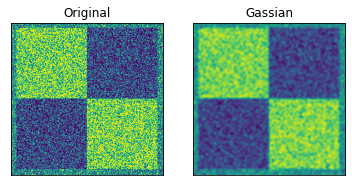

In [13]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
img3 = cv.imread('images/ps1-input0-noise.png')
img3 = cv2.cvtColor(img3, cv2.COLOR_RGB2GRAY)
blur = cv.GaussianBlur(img3,(5,5),50)

plt.subplot(121),plt.imshow(img3),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(blur),plt.title('Gassian')
plt.xticks([]), plt.yticks([])
plt.show()

**B -** Usando um operador de borda de sua escolha, crie uma imagem de borda binária para a imagem original (`ps1-input0-noise.png`) e a versão suavizada acima.

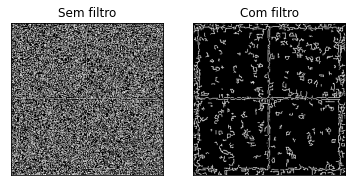

True

In [14]:
edges1 = cv2.Canny(img3,100,200)
edges2 = cv2.Canny(blur,100,200)
plt.subplot(121),plt.imshow(edges1,cmap = 'gray')
plt.title('Sem filtro'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges2,cmap = 'gray')
plt.title('Com filtro'), plt.xticks([]), plt.yticks([])
plt.show()

cv2.imwrite("edges2.png", edges2) 

**C -** Agora aplique seu método de Hough à versão suavizada da imagem da borda. Seu objetivo é ajustar os algoritmos de filtragem, localização de bordas e Hough para encontrar as linhas da melhor maneira possível neste caso de teste.

In [15]:
img = cv2.imread("edges2.png")
init(img)
grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
smooth = cv.GaussianBlur(grey,(5,5),10)
houghSpace = hough_lines_acc(grey)
peaks = hough_peaks(houghSpace, 20)
hough_draw_peaks(houghSpace, peaks)
hough_draw_lines(img, peaks)

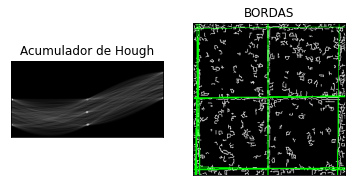

In [16]:
plt.subplot(121),plt.imshow(houghSpace,cmap = 'gray')
plt.title('Acumulador de Hough'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img,cmap = 'gray')
plt.title('BORDAS'), plt.xticks([]), plt.yticks([])
plt.show()

O que você precisou fazer para obter seus melhores resultados?

### 4 - Detecção de linhas em imagem real

A imagem `ps1-input1.png` contém objetos cujos limites são círculos (moedas) ou linhas (canetas).

<img src="images/ps1-input1.png" width="300"/>

 Para esta pergunta, você ainda encontra linhas.

**A -** Gere uma versão monocromática da imagem (você pode escolher um único canal de cor ou usar uma função de conversão de cor para escala de cinza integrada) e compute uma versão moderadamente suavizada dessa imagem usando um filtro Gaussiano. Novamente, escolha o $\sigma$ do filtro com pelo menos alguns pixels de tamanho.

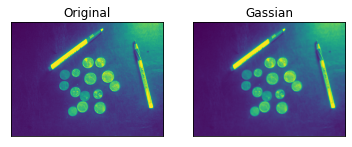

In [17]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
img4 = cv.imread('images/ps1-input1.png')
img4 = cv2.cvtColor(img4, cv2.COLOR_RGB2GRAY)
blur1 = cv.GaussianBlur(img4,(5,5),1.6)

plt.subplot(121),plt.imshow(img4),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(blur1),plt.title('Gassian')
plt.xticks([]), plt.yticks([])
plt.show()

**B -** Crie uma imagem de borda para a versão suavizada da imagema acima

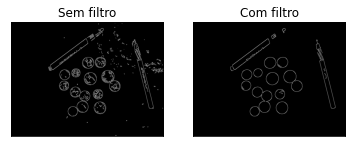

In [18]:
edges3 = cv2.Canny(img4,100,200)
edges4 = cv2.Canny(blur1,100,200)
plt.subplot(121),plt.imshow(edges3,cmap = 'gray')
plt.title('Sem filtro'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges4,cmap = 'gray')
plt.title('Com filtro'), plt.xticks([]), plt.yticks([])
plt.show()

In [19]:
cv2.imwrite("edges4.png", edges4) 

True

**C -** Aplique seu algoritmo de Hough à imagem de borda para encontrar linhas ao longo das canetas e desenhe as linhas coloridas na imagem monocromática original (não na imagem de borda), não se preocupe com as linhas desenhadas se estendendo até o limite da imagem.

In [20]:
img = cv2.imread("edges4.png")
init(img)
grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
smooth = cv.GaussianBlur(grey,(5,5),50)
houghSpace = hough_lines_acc(grey)
peaks = hough_peaks(houghSpace, 10)
hough_draw_peaks(houghSpace, peaks)
hough_draw_lines(img, peaks)

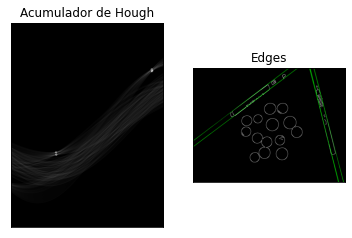

In [21]:
plt.subplot(121),plt.imshow(houghSpace,cmap = 'gray')
plt.title('Acumulador de Hough'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img,cmap = 'gray')
plt.title('Edges'), plt.xticks([]), plt.yticks([])
plt.show()